# Random sweeps, Metrics mismatch

Collection of plots for chapter 6.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data

import re
import inspect
import imp

import utils
import load_experimental_data
import highdimensionnetwork
import hierarchicalrandomnetwork

from mpl_toolkits.mplot3d import Axes3D

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Metric mismatch grid plot

In [3]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if "std_" + interpolate_column in df:
        w = 1./df["std_" + interpolate_column]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', 
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    x_int_space = np.sort(df[x_col].unique())
    y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                xlabel_format="%d", 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [7]:
%cd /nfs/data3/lmatthey/visual_working_mem/thesis_plots/random_sweeps_metric_mismatch
with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_metricmismatch_ratiosigmax_grid_020118.py

/nfs/data3/lmatthey/visual_working_mem/thesis_plots/random_sweeps_metric_mismatch


In [8]:
dataio = DataIO(
    output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', 
    label=dataset_infos['save_output_filename'])
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='thesis_plots/random_sweeps_metrics_mismatch')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/thesis_plots/random_sweeps_metric_mismatch/metricmismatch_ratiosigmax_grid_1try_repetitions3_020118/outputs/metricmismatch_bays09_ratiosigmax-<module>-643429b7-6691-4044-9ce1-5b3c6fbe289d ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/thesis_plots/random_sweeps_metric_mismatch/metricmismatch_ratiosigmax_grid_1try_repetitions3_020118/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/thesis_plots/random_sweeps_metrics_mismatch/metricmismatch_ratiosigmax_grid_1try_repetitions3_020118_outputs
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/thesis_plots/random_sweeps_metric_mismatch/metricmismatch_ratiosigmax_grid_1try_repetitions3_020118/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/thesis_plots/random_sweeps_metrics_mismatch/metricmismatch_ra

In [26]:
# Extract data
result_ll_sum_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['results_flat'])
result_ll90_sum_flat = np.array(data_pbs.dict_arrays['result_ll90_sum']['results_flat'])
result_ll_median_flat = np.array(data_pbs.dict_arrays['result_ll_median']['results_flat'])
result_precision_flat = np.array(data_pbs.dict_arrays['result_precision']['results_flat'])
result_em_fits_flat = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_emfit_mse_flat = np.array(data_pbs.dict_arrays['result_emfit_mse']['results_flat'])
result_emfit_mixt_kl_flat = np.array(data_pbs.dict_arrays['result_emfit_mixt_kl']['results_flat'])
result_fi_theo_flat = np.array(data_pbs.dict_arrays['result_fi_theo']['results_flat'])
result_fi_theocov_flat = np.array(data_pbs.dict_arrays['result_fi_theocov']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_ll_sum']['repeats_completed']

M_space = np.unique(result_parameters_flat[:, 0])
ratio_conj_space = np.unique(result_parameters_flat[:, 1])
sigmax_space = np.unique(result_parameters_flat[:, 2])

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

result_parameters_flat = result_parameters_flat[all_repeats_completed == (num_repetitions - 1)]
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

# Compute lots of averages over the repetitions
result_ll_sum_avg = utils.nanmean(result_ll_sum_flat, axis=-1)
result_ll90_sum_avg = utils.nanmean(result_ll90_sum_flat, axis=-1)
result_em_fits_avg = utils.nanmean(result_em_fits_flat, axis=-1)
result_emfit_mse_avg = utils.nanmean(result_emfit_mse_flat, axis=-1)
result_emfit_mixt_kl_avg = utils.nanmean(result_emfit_mixt_kl_flat, axis=-1)
result_ll_median_avg = utils.nanmean(result_ll_median_flat, axis=-1)

# Compute best results
result_dist_emfit_mse = np.nansum(np.nansum(result_emfit_mse_avg, axis=-1), axis=-1)
result_dist_emfit_fidelity = np.nansum(result_emfit_mse_avg[..., 0], axis=-1)
result_dist_emfit_kl = np.nansum(result_emfit_mixt_kl_avg, axis=-1)
result_dist_nll = np.nansum(-result_ll_sum_avg, axis=-1)
result_dist_nll90 = np.nansum(-result_ll90_sum_avg, axis=-1)
result_dist_nll_median = np.nansum(-result_ll_median_avg, axis=-1)

# Get the best fitting parameters
best_params_em = np.argsort(result_dist_emfit_mse)
best_params_kl = np.argsort(result_dist_emfit_kl)
best_params_ll = np.argsort(result_dist_nll)
best_params_ll90 = np.argsort(result_dist_nll90)

# Pandas
df_all_fits = pd.DataFrame.from_items([('M', result_parameters_flat[:, 0]),
                                       ('ratio_conj', result_parameters_flat[:, 1]),
                                       ('sigmax', result_parameters_flat[:, 2]),
                                       ('dist_emfit_mse', result_dist_emfit_mse),
                                       ('dist_emfit_fidelity', result_dist_emfit_fidelity),
                                       ('dist_emfit_kl', result_dist_emfit_kl),
                                       ('dist_nll', result_dist_nll),
                                       ('dist_nll90', result_dist_nll90),
                                       ('dist_nll_median', result_dist_nll_median),
                                      ])
df_all_fits = df_all_fits.assign(dist_emfit_mse_log = lambda x: np.log(x['dist_emfit_mse']),
                                 dist_emfit_kl_log = lambda x: np.log(x['dist_emfit_kl']),
                                 dist_nll_log = lambda x: np.log(x['dist_nll']),
                                 dist_nll90_log = lambda x: np.log(x['dist_nll90']),
                                )


In [27]:
# Remove outliers
df_fits_filtered = utils.remove_outliers(df_all_fits, 5)

# Keep M=100 only
# df_fits_filtered = df_fits_filtered[df_fits_filtered.M == 100]

In [28]:
# f, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].scatter(result_parameters_flat[:, 1], result_parameters_flat[:, 2], c=result_dist_emfit_mse)
# axes[1].scatter(result_parameters_flat[:, 1], result_parameters_flat[:, 2], c=result_dist_emfit_kl)

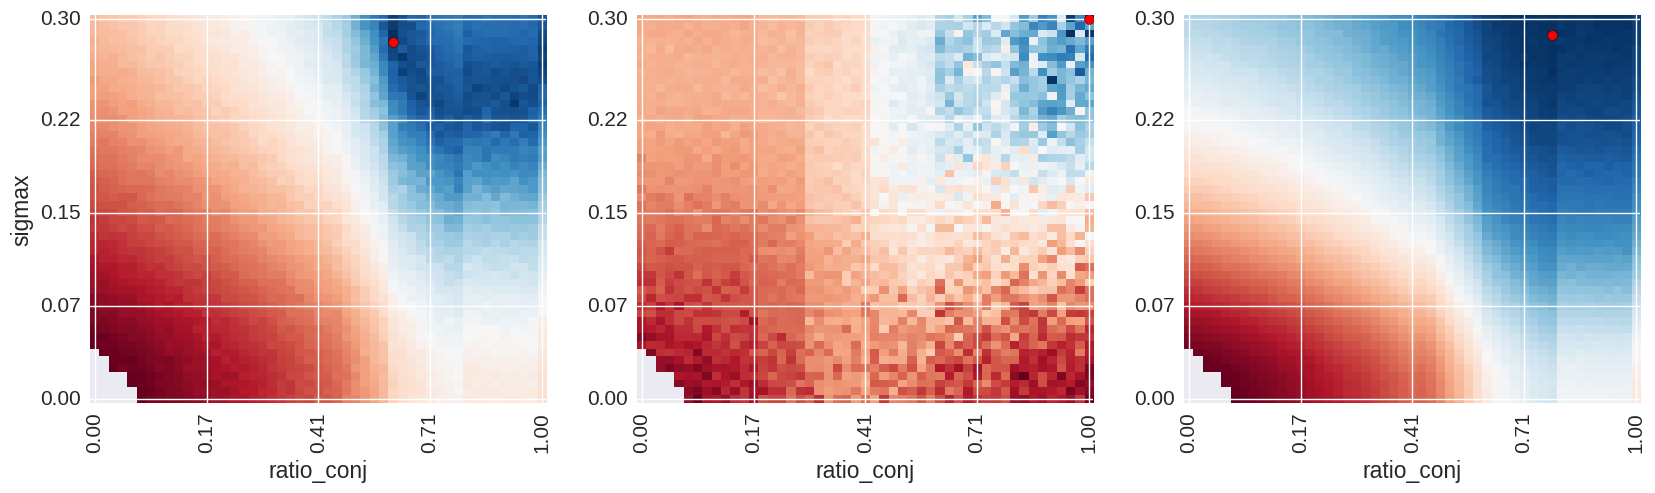

In [29]:
data_mse = df_fits_filtered.pivot_table(index='ratio_conj', 
                                            columns='sigmax', 
                                            values='dist_emfit_fidelity').as_matrix()
data_kl = df_fits_filtered.pivot_table(index='ratio_conj', 
                                            columns='sigmax', 
                                            values='dist_emfit_kl').as_matrix()
data_nll = df_fits_filtered.pivot_table(index='ratio_conj', 
                                            columns='sigmax', 
                                            values='dist_nll').as_matrix()


f, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()
utils.pcolor_2d_data(data_mse, x=ratio_conj_space, y=sigmax_space, 
                     xlabel="ratio_conj", ylabel="sigmax", xlabel_format = "%.2f", colorbar=False,
                     ticks_interpolate=5, cmap='RdBu_r', log_scale=True, ax_handle=axes[0])

utils.pcolor_2d_data(data_kl, x=ratio_conj_space, y=sigmax_space, 
                     xlabel="ratio_conj", xlabel_format = "%.2f", colorbar=False,
                     ticks_interpolate=5, cmap='RdBu_r', log_scale=True, ax_handle=axes[1])
utils.pcolor_2d_data(data_nll, x=ratio_conj_space, y=sigmax_space, 
                     xlabel="ratio_conj", xlabel_format = "%.2f", colorbar=False,
                     ticks_interpolate=5, cmap='RdBu_r', log_scale=True, ax_handle=axes[2])

# Best points
best_mse = np.unravel_index(np.nanargmin(data_mse), data_nll.shape)
best_kl = np.unravel_index(np.nanargmin(data_kl), data_nll.shape)
best_nll = np.unravel_index(np.nanargmin(data_nll), data_nll.shape)

axes[0].scatter(best_mse[0], best_mse[1], c='red', s=50)
axes[1].scatter(best_kl[0], best_kl[1], c='red', s=50)
axes[2].scatter(best_nll[0], best_nll[1], c='red', s=50)

In [278]:
f.savefig(dataio.create_formatted_filename("metricmismatch_horiz_{label}_{unique_id}.pdf"))

## Quantize parameters

In [218]:
# Quantize parameters to smooth stuff up a bit

nQuantiles = 25
parameters = ['ratio_conj', 'sigmax']

df_fits_quants, param_qbins, param_qbins_middle = utils.df_add_quantize_parameters(
    df_fits_filtered, parameters, nQuantiles)
df_fits_q_avg = df_fits_quants.groupby(('ratio_conj_qi', 'sigmax_qi')).mean().reset_index()

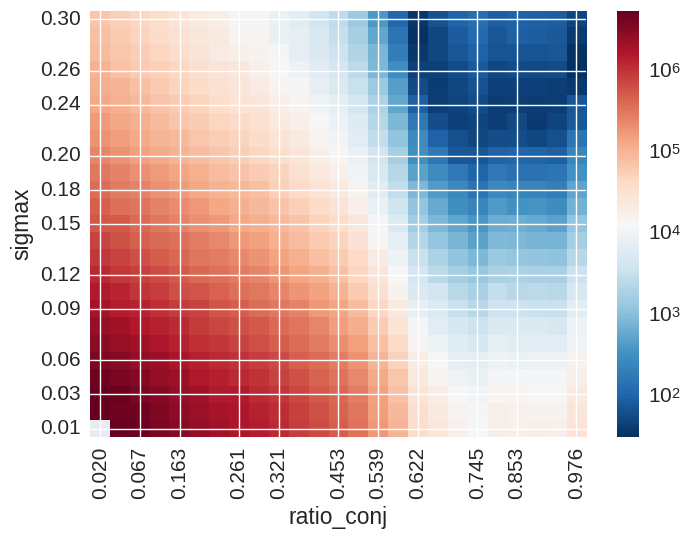

In [220]:
data_q_ratio_sigmax = df_fits_q_avg.pivot_table(index='ratio_conj_qi', 
                                                columns='sigmax_qi', 
                                                values='dist_emfit_mse'
                                               ).as_matrix()

ax, _ = utils.pcolor_2d_data(data_q_ratio_sigmax, 
                             x=param_qbins_middle['ratio_conj'], y=param_qbins_middle['sigmax'], 
                             xlabel="ratio_conj", ylabel="sigmax", xlabel_format = "%.3f", 
                             ticks_interpolate=11, cmap='RdBu_r', log_scale=True)